# Import Library

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import re
from os import getcwd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cwd = getcwd() + "/drive/Shareddrives/CAPSTONE_ML/"
print(cwd)

/content/drive/Shareddrives/CAPSTONE_ML/


In [66]:
df_all = pd.read_excel(cwd + "df_all_new.xlsx")
df_all.head()

,Page_URL,Shop_name,Rating,Reviews,Kategori,Address,Phone_Number,Opening_Hours,Range_Harga,Latitude,Longitude,Eco_Friendly,Categorize_Weather
0,https://www.google.com/maps/place/Wedang+Uwuh+...,Wedang Uwuh Solo - Pak Aden,4.6,5,Wedang Uwuh,"Mutihan rt 04 rw 1, Surakarta, Sondakan, Kec. ...",082324006000,"{'Senin': ['08.00–20.00'], 'Selasa': ['08.00–2...",Rp 1–25 rb,-7.566731,110.716919,0,Dingin
1,https://www.google.com/maps/place/Rajanya+JAHE...,Rajanya JAHE REMPAH wedhang uwuh Sumber,4.6,32,Wedang Uwuh,"Jl. Letjen Suprapto No.76c, Sumber, Kec. Banja...",085641727445,"{'Minggu': ['Buka 24 jam'], 'Senin': ['Buka 24...",Rp 1–25 rb,-7.566731,110.716919,0,Dingin
2,https://www.google.com/maps/place/Wedang+uwuh+...,Wedang uwuh jelantik solo,5.0,1,Wedang Uwuh,"Jl. Sungai Musi No.1, Sangkrah, Kec. Ps. Kliwo...",081229070267,"{'Senin': ['Buka 24 jam'], 'Selasa': ['Buka 24...",Rp 1–25 rb,-7.576765,110.768229,0,Dingin
3,https://www.google.com/maps/place/Wedang+uwuh+...,Wedang uwuh mbok tuo,4.9,14,Wedang Uwuh,"Jl. Kutai Tim. 5B, RT.05/RW.08, Sumber, Kec. B...",081578614885,"{'Senin': ['07.00–19.00'], 'Selasa': ['07.00–1...",Rp 1–25 rb,-7.547894,110.730811,0,Dingin
4,https://www.google.com/maps/place/wedang+uwuh+...,wedang uwuh sya,4.7,3,Wedang Uwuh,"Jl. Reksoniten No.20, Gajahan, Kec. Ps. Kliwon...",089608149211,"{'Minggu': ['Buka 24 jam'], 'Senin': ['Buka 24...",Rp 1–25 rb,-7.547894,110.730811,0,Dingin


Fungsi untuk menghitung jarak menggunakan formula haversine

In [4]:
def calculate_haversine(lat1, lon1, lat2, lon2):
    earth_radius = 6371  # Radius bumi dalam kilometer
    delta_lat = np.radians(lat2 - lat1)
    delta_lon = np.radians(lon2 - lon1)
    a = np.sin(delta_lat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(delta_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return earth_radius * c

Menghitung jarak tiap lokasi berdasarkan input latitude dan longitude pengguna

In [5]:
# Lokasi pengguna
current_lat = -7.5589608
current_lon = 110.856106

# Perhitungan jarak untuk setiap lokasi dalam dataset
df_all['computed_distance'] = df_all.apply(
    lambda row: calculate_haversine(current_lat, current_lon, row['Latitude'], row['Longitude']), axis=1
)

Persiapan data untuk model


In [ ]:
# C = df_all['Rating'].mean()
# M = df_all['Reviews'].quantile(0.5)

# # Hitung Weighted Rating
# df_all['weighted_rating'] = ((df_all['Reviews'] / (df_all['Reviews'] + M)) * df_all['Rating']) + ((M / (df_all['Reviews'] + M)) * C)

# # Menyiapkan data fitur dan target
# features = df_all[['computed_distance', 'weighted_rating']]
# target = df_all['computed_distance']  # Target jarak untuk pemeringkatan

# # Normalisasi data fitur
# scaler = MinMaxScaler()
# features_normalized = scaler.fit_transform(features)

# # Membagi dataset menjadi training dan testing
# X_train, X_test, y_train, y_test = train_test_split(features_normalized, target, test_size=0.2, random_state=42)


# dataset = tf.data.Dataset.from_tensor_slices(dict(X_train), y_train)
# dataset = dataset.shuffle().batch(100)

In [18]:
# Hitung Weighted Rating
C = df_all['Rating'].mean()
M = df_all['Reviews'].quantile(0.5)
df_all['weighted_rating'] = ((df_all['Reviews'] / (df_all['Reviews'] + M)) * df_all['Rating']) + ((M / (df_all['Reviews'] + M)) * C)

# Menyiapkan data fitur dan target
features = df_all[['weighted_rating']]
target = df_all['computed_distance']  # Target jarak untuk pemeringkatan

# Normalisasi data fitur
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

# Membagi dataset menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(features_normalized, target.to_numpy(), test_size=0.2, random_state=42)

# Pastikan bentuk data benar
print("X_train shape:", X_train.shape)  # (jumlah_data, jumlah_fitur)
print("y_train shape:", y_train.shape)  # (jumlah_data,)

# Buat dataset TensorFlow
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Opsional: Tambahkan shuffling dan batching
dataset = dataset.shuffle(buffer_size=100).batch(32)

KeyError: 'computed_distance'

Membuat arsitektur model. Menggunakan adam optimizer dan loss Mean Squared Error dan menambahkan metrics mae (pengennya accuracy)

In [7]:
# Membuat arsitektur model
model1 = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dropout(0.1),
    # tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

# Kompilasi model
model1.compile(optimizer='adam', loss="mse", metrics=['mae'])  # Loss: Mean Squared Error, Metrics: Mean Absolute Error

Memulai proses training dan menyimpannya kedalam variable history

In [8]:
history = model1.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 140.8847 - mae: 9.3797 - val_loss: 83.8054 - val_mae: 7.5296
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 109.8308 - mae: 7.3697 - val_loss: 27.5229 - val_mae: 4.3801
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 49.6359 - mae: 5.2999 - val_loss: 30.0246 - val_mae: 4.7671
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 55.0730 - mae: 5.2309 - val_loss: 27.7966 - val_mae: 4.3543
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 46.0949 - mae: 4.7534 - val_loss: 28.7193 - val_mae: 4.6524
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 59.3763 - mae: 5.4571 - val_loss: 27.7222 - val_mae: 4.5347
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 48.7810 - mae: 5.0759 - val_loss: 27.4946 - val_mae: 4.4924
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 51.7756 - mae: 5.0530 - val_loss: 28.1815 - val_mae: 4.5965
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8

Menguji performa model setelah dilakukan training

In [9]:
test_loss, test_mae = model1.evaluate(X_test, y_test, verbose=0)
print(f"Mean Absolute Error pada data uji: {test_mae}")

Mean Absolute Error pada data uji: 5.39303731918335


In [11]:
# Membuat prediksi pada data baru
df_all['predicted_distance'] = model1.predict(features_normalized)

# Mendapatkan rekomendasi berdasarkan jarak terprediksi
top_recommendations = df_all.sort_values(by=['computed_distance', 'predicted_distance'], ascending=True).head(20)



# Menampilkan rekomendasi
print("Rekomendasi teratas berdasarkan prediksi jarak:")
print(top_recommendations[['Shop_name', 'Latitude', 'Longitude', 'Rating', 'Reviews', 'Categorize_Weather', 'computed_distance','predicted_distance']])


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Rekomendasi teratas berdasarkan prediksi jarak:
                                             Shop_name  Latitude   Longitude  \
453                    Sate Kambing Muda Kondang Laris -7.555006  110.858501   
273                                        SELAT LARAS -7.563668  110.853368   
50                                   Cafe Bukuku Lawas -7.560393  110.850782   
45                                       Kedai Bedjono -7.549122  110.857902   
287                                     Sop Kwali Solo -7.555214  110.844744   
59                                 Wedangan Mas Bonnie -7.571119  110.852502   
253                                         Omah Selat -7.566417  110.843382   
486                                Sate Babi Pak Ciwir -7.564732  110.841051   
176                            Warung Soto Daging Sapi -7.560530  110.838981   
478                                  Sate Babi Koh Gun -7.569508  110.842028   
262  Vien's Selat Cabang Rumah Sa

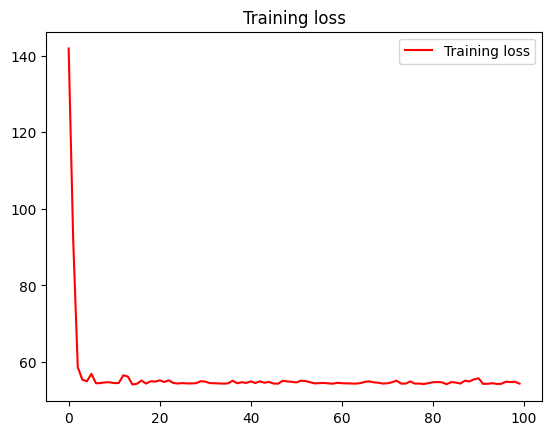

In [15]:
# Plot the training loss for each epoch
import matplotlib.pyplot as plt

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

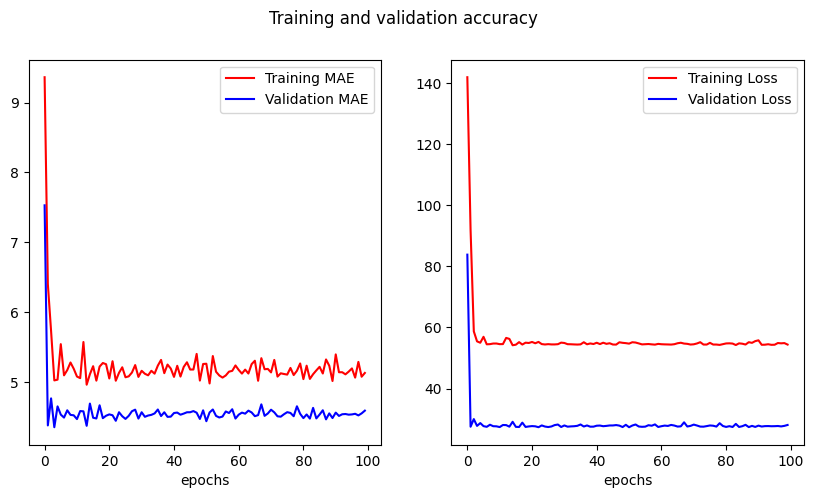

In [16]:
# Get training and validation accuracies
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(mae))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(mae, val_mae), (loss, val_loss)], ["MAE", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [71]:
# Normalize numerical features
# Hitung Weighted Rating
C = df_all['Rating'].mean()
M = df_all['Reviews'].quantile(0.5)
df_all['weighted_rating'] = ((df_all['Reviews'] / (df_all['Reviews'] + M)) * df_all['Rating']) + ((M / (df_all['Reviews'] + M)) * C)

# Menyiapkan data fitur dan target
import re

def process_range_harga(value):
    # Hilangkan karakter non-numerik
    value = re.sub(r'[^\d\-]', '', str(value))
    try:
        min_val, max_val = map(int, value.split('-'))
        return (min_val + max_val) / 2  # Ambil rata-rata
    except:
        return np.nan

df_all['Range_Harga_Processed'] = df_all['Range_Harga'].apply(process_range_harga)
df_all['Range_Harga_Processed'] = df_all['Range_Harga_Processed'].fillna(df_all['Range_Harga_Processed'].median())
df_all['Range_Harga_Normalized'] = scaler.fit_transform(df_all[['Range_Harga_Processed']])

# One-hot encode categorical features
ohe_kategori = OneHotEncoder(sparse_output=False)
kategori_encoded = ohe_kategori.fit_transform(df_all[['Kategori']])

ohe_weather = OneHotEncoder(sparse_output=False)
categorize_weather_encoded = ohe_weather.fit_transform(df_all[['Categorize_Weather']])

# Combine features into a single input
features = np.hstack([
    df_all[['Range_Harga_Normalized']].values,
    kategori_encoded,
    df_all[['weighted_rating']].values,
    categorize_weather_encoded,
])

# Define labels: High rating (e.g., > 4.0) as positive
# threshold = 0.0
labels = df_all['Rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

[[nan  0.  0. ...  1.  0.  0.]
 [nan  0.  0. ...  0.  1.  0.]
 [nan  0.  1. ...  0.  0.  1.]
 ...
 [nan  0.  0. ...  1.  0.  0.]
 [nan  0.  0. ...  0.  1.  0.]
 [nan  0.  0. ...  1.  0.  0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:695: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:712: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [70]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dropout(0.1),
    # tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Evaluate model performance
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: n

In [62]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Features (InputLayer)                │ (None, 23)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Recommendation_Score (Dense)         │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,181 (133.52 KB)

 Trainable params: 11,393 (44.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,788 (89.02 KB)

In [64]:
# Predict recommendation scores
df_all['Recommendation_Score'] = model.predict(X_test)

# Tambahkan skor ke data uji
# df_recommendations = df_all.iloc[X_test.argmax(axis=0)].copy()
# df_recommendations['Recommendation_Score'] = recommendation_scores

# Sort by highest recommendation score
# df_recommendations = df_recommendations.sort_values(by='Recommendation_Score', ascending=False)

# Print top recommendations
print(df_all[['Shop_name', 'Recommendation_Score']].head(10))
print(features.shape)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ValueError: Length of values (122) does not match length of index (607)